#**Abstractive = T5 and Pegesus** 

In [ ]:
!pip install --quiet transformers==4.5.0
# !pip install --quiet pytorch-lightening==1.2.7

In [ ]:
!pip install pytorch-lightning #Lightning is a high-level python framework built on top of Pytorch.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning #importing base model from git hub
import pytorch_lightning as pl
print(pl.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-m6ycokty
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-m6ycokty
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
1.8.0rc0


###Importing Required Libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import transformers
from pathlib import *
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

from tqdm.auto import tqdm

In [ ]:
#visulaizing libraries
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10
pl.seed_everything(42)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

###Importing Scrapped Dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final_Dataset.csv", header=0)
df.head()

,Unnamed: 0,id,title,text,summary,authors,url,publish_date,language,keywords
0,0,0,Podcast: Cry Like a Boy explores the pressures...,Cry Like a Boy is an original podcast series f...,We will also discuss how the involvement of me...,NaN,https://www.euronews.com/culture/2020/12/23/po...,2020-12-23 00:00:00,en,"zama, linked, episode, podcast, burundi, man, ..."
1,0,1,"Ukraine war: New Russian 'gas hub' in Turkey, ...","1. No 'massive' strikes planned for Ukraine, s...",Turkey starts work on Putin's proposed new gas...,NaN,https://www.euronews.com/2022/10/14/ukraine-wa...,2022-10-14 00:00:00,en,"russian, kherson, ukrainian, bridge, ukraine, ..."
2,0,2,Europe's week: Russian missiles strike Ukraine...,Here is a roundup of Europe's top stories from...,As the Ukrainian counteroffensive in the east ...,NaN,https://www.euronews.com/my-europe/2022/10/14/...,2022-10-14 00:00:00,en,"week, tensions, russian, europes, escalate, uk..."
3,0,3,Ukraine war: Russian army will be 'annihilated...,A Russian nuclear strike against Ukraine would...,A Russian nuclear strike against Ukraine would...,NaN,https://www.euronews.com/my-europe/2022/10/13/...,2022-10-13 00:00:00,en,"russian, garden, ukraine, nuclear, borrell, eu..."
4,0,4,Ukraine war: 'Come back to the negotiating tab...,"Emmanuel Macron has urged Vladimir Putin to ""c...","Emmanuel Macron has urged Vladimir Putin to ""c...",NaN,https://www.euronews.com/2022/10/13/ukraine-wa...,2022-10-13 00:00:00,en,"russian, france, macron, air, ukraine, defence..."


In [ ]:
df.shape

(7000, 10)

In [ ]:
df = df[["text","summary"]]
df = df.dropna()
df.head()

,text,summary
0,Cry Like a Boy is an original podcast series f...,We will also discuss how the involvement of me...
1,"1. No 'massive' strikes planned for Ukraine, s...",Turkey starts work on Putin's proposed new gas...
2,Here is a roundup of Europe's top stories from...,As the Ukrainian counteroffensive in the east ...
3,A Russian nuclear strike against Ukraine would...,A Russian nuclear strike against Ukraine would...
4,"Emmanuel Macron has urged Vladimir Putin to ""c...","Emmanuel Macron has urged Vladimir Putin to ""c..."


In [ ]:
df.shape

(6999, 2)

### Using t5 scratch

In [ ]:
train_df, test_df=train_test_split(df,test_size=0.15) #splitting dataset for training(85%) and testing (15%)
train_df.shape, test_df.shape

((5949, 2), (1050, 2))

In [ ]:
MODEL_NAME="t5-base"     #importing t5base model, pretrained  on c4
tokenizer=T5Tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
text_token_counts, summary_token_counts= [],[]

for _, row in train_df.iterrows():
  text_token_count=len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)

  summary_token_count=len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Full summary token counts')

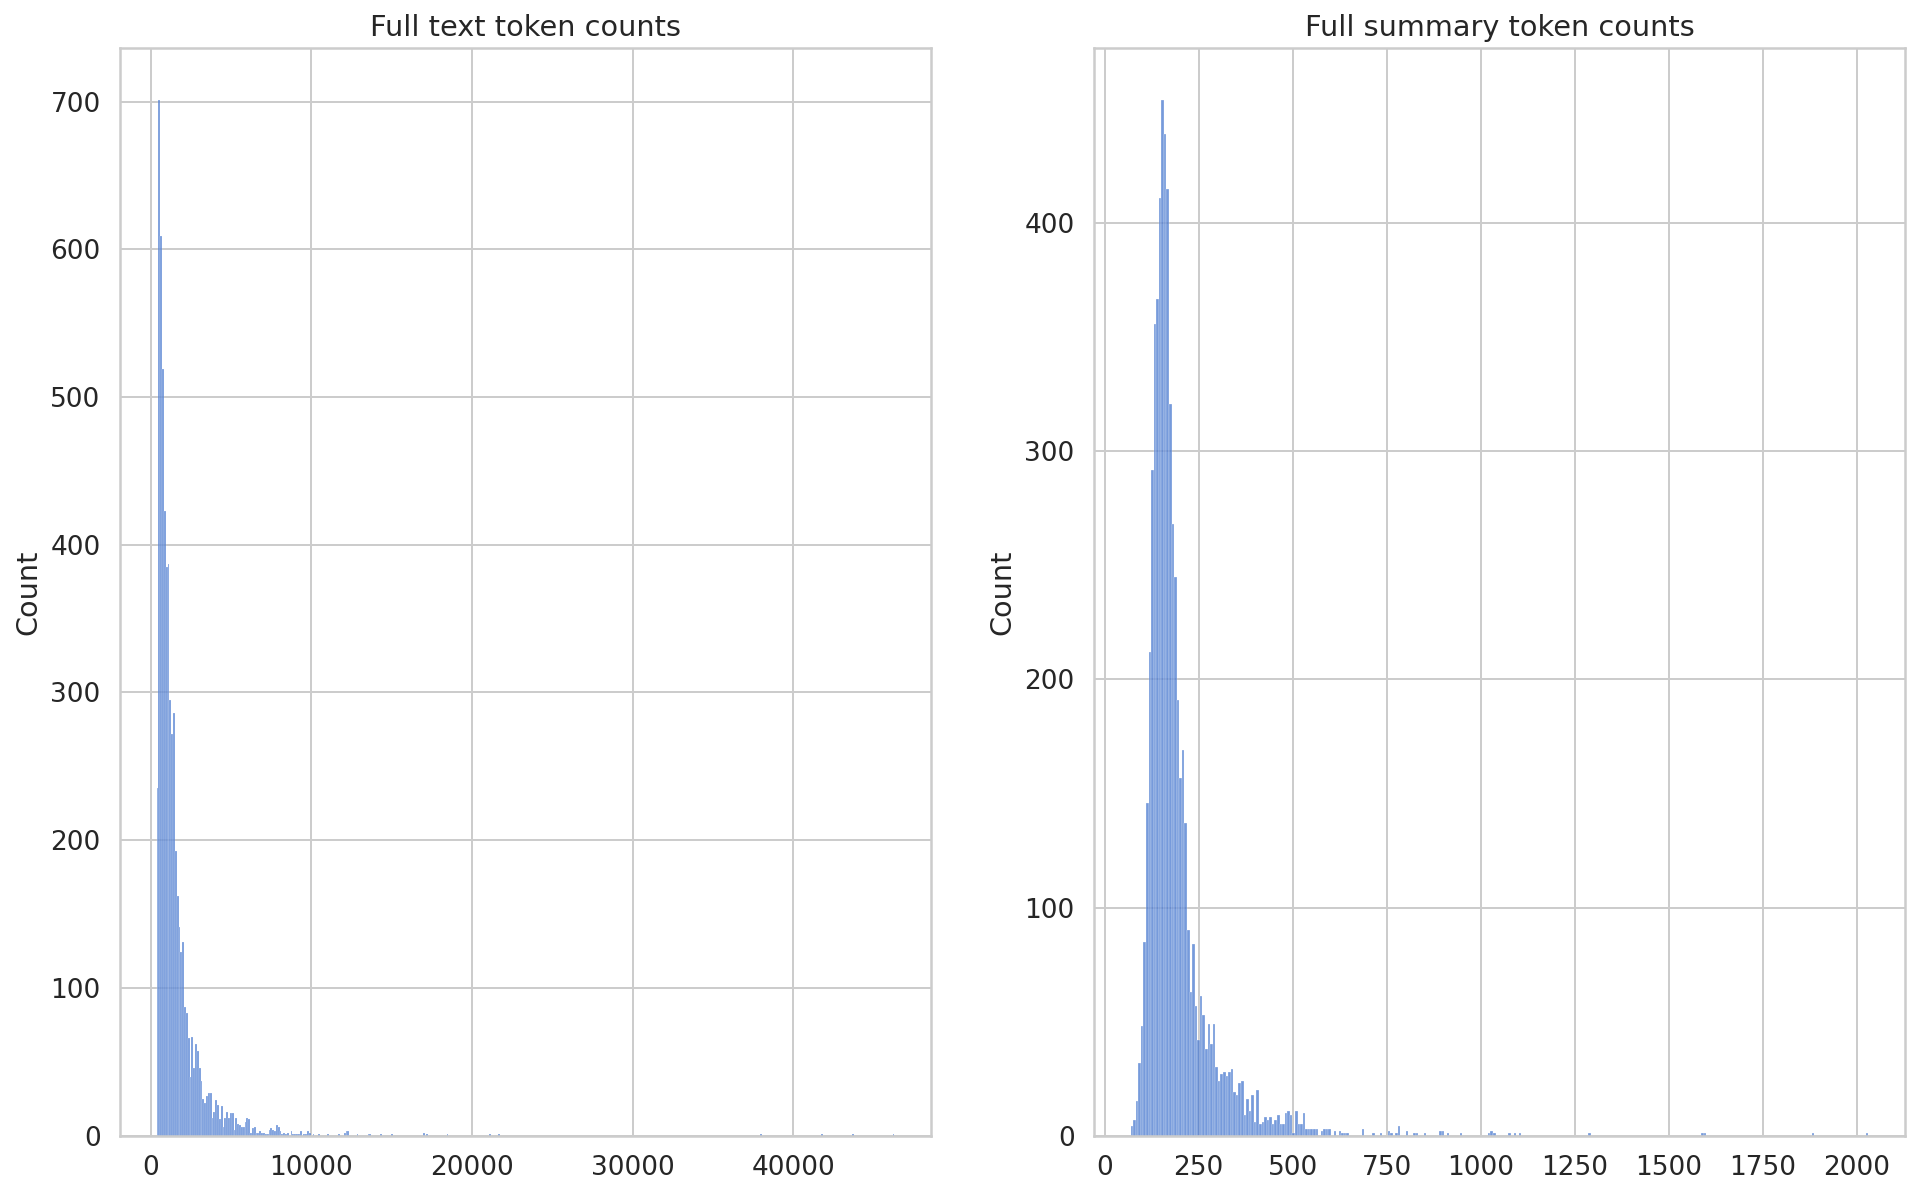

In [ ]:
#visualising Text and summary token counts
fig, (ax1,ax2)=plt.subplots(1,2)
sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")
sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Full summary token counts")

In [ ]:
class NewsSummaryDataset(Dataset):

  def __init__(
      self,
      data: pd.DataFrame,
      tokenizer: T5Tokenizer,
      batch_size: int =8,
      text_max_token_len: int =128,
      summary_max_token_len: int =128
  ):
      self.tokenizer=tokenizer
      self.data=data
      self.batch_size=batch_size
      self.text_max_token_len=text_max_token_len
      self.summary_max_token_len= summary_max_token_len


  def __len__(self):
    return len(self.data)

  def __getitem__(self, index:int):
    data_row=self.data.iloc[index]
    text=data_row["text"]


    text_encoding=tokenizer( #text encoding
        text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
        
    )

    summary_encoding=tokenizer( #summary encoding
        data_row["summary"],
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
        
    )


    labels= summary_encoding["input_ids"]                 #token are converted into int so those ar the input ids
    labels[labels==0]= -100                              ##??? uknwokn i.e empty space is assigned as -100

    return dict(
        text=text,
        summary=data_row["summary"],
        text_input_ids=text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=summary_encoding["attention_mask"].flatten()

    )


In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
  def __init__(
      self,
      train_df: pd.DataFrame,
      test_df: pd.DataFrame,
      tokenizer: T5Tokenizer,
      batch_size: int= 8,
      text_max_token_len: int =512,
      summary_max_token_len: int =128

  ):
      super().__init__()
      self.train_df=train_df
      self.test_df=test_df
      self.batch_size=batch_size
      self.tokenizer=tokenizer
      self.text_max_token_len=text_max_token_len
      self.summary_max_token_len=summary_max_token_len

  def setup(self, stage=None):
    self.train_dataset=NewsSummaryDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len

    )
    self.test_dataset=NewsSummaryDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len

    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )

In [ ]:
N_EPOCHS=3
BATCH_SIZE=8
data_module=NewsSummaryDataModule(train_df,test_df, tokenizer, batch_size=BATCH_SIZE)

In [ ]:
class NewsSummaryModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

  def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):
    output= self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )

    return output.loss, output.logits

  def training_step(self,batch,batch_idx):
    input_ids=batch["text_input_ids"]
    attention_mask=batch["text_attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("train_loss",loss, prog_bar=True,logger=True)                  #progbar?
    return loss


  def validation_step(self,batch,batch_idx):
    input_ids=batch["text_input_ids"]
    attention_mask=batch["text_attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("val_loss",loss, prog_bar=True,logger=True)
    return loss

  def test_step(self,batch,batch_idx):
    input_ids=batch["input_ids"]
    attention_mask=batch["attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("test_loss",loss, prog_bar=True,logger=True)
    return loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=0.0001)



In [ ]:
model=NewsSummaryModel()

In [ ]:
#creating checkpint function
checkpoint_callback= ModelCheckpoint(
    dirpath="/content/drive/MyDrive/project/checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger= TensorBoardLogger("lightning_logs",name="news-summary")

In [ ]:
trainer=pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    gpus=1
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#trainer.fit(model,data_module)

In [ ]:
trained_model=NewsSummaryModel.load_from_checkpoint(
    "/content/drive/MyDrive/project/checkpoints/best-checkpoint.ckpt", #trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

In [ ]:
def summarize(text):
  text_encoding=tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids=trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2,
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )


  preds = [
      tokenizer.decode(gen_id,skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  return  "".join(preds)

In [ ]:
sample_row=test_df.iloc[1]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [ ]:
text  #original text

'China’s BYD Auto, the world’s largest electric vehicle maker, is exploring contract manufacturing and expanding its assembly operations for building EVs in India amid tightened foreign investment rules for countries sharing a land border with India.\n\nBYD Auto’s India unit is exploring several options to make EVs in India, said Sanjay Gopalakrishnan, senior vice-president of electric passenger vehicle business, BYD India.\n\nIndia tightened scrutiny on investments from China in retaliation against Chinese troop incursions in the Ladakh region.\n\nIndian and Chinese troops clashed along the disputed Himalayan border in May 2020, killing 20 Indian soldiers and an unspecified number of their Chinese counterparts.\n\nThe developments have scuttled the investment plans of several Chinese companies, including Great Wall Motor, which shut its India operations earlier this year after it failed to secure government approval for its $1 billion investment proposal.\n\nBYD has an annual assembly

In [ ]:
sample_row["summary"]    #original summary

'BYD Auto’s India unit is exploring several options to make EVs in India, said Sanjay Gopalakrishnan, senior vice-president of electric passenger vehicle business, BYD India.\nBYD has an annual assembly capacity of 10,000 units in Chennai, India, which can be expanded to 15,000 units.\nThe EV maker launched its Atto 3 e-sport-utility vehicle (SUV) in India on Tuesday, its first passenger electric vehicle for the local market.\nSo now BYD is doing global business in a big way in the passenger vehicle business.\nBYD India has also signed up prominent dealers, such as the Landmark Group, as business partners in key cities.'

In [ ]:
model_summary   #model predicted summary

'China’s BYD Auto, the world’s largest electric vehicle maker, is exploring contract manufacturing and expanding its assembly operations for building EVs in India amid tightened foreign investment rules for countries sharing a land border with India. BYD Auto’s India unit is exploring several options to make EVs in India, said Sanjay Gopalakrishnan, senior vice-president of electric passenger vehicle business, BYD India. The Shenzhen-based company has set itself a lofty goal of achieving a 40% market share of India’s EV market by 2030.'

### USing Pretrained model

Pegasus-xsum


In [ ]:
import transformers
from transformers import pipeline, set_seed
from transformers import AutoTokenizer
#transformers.utils.move_cache()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")    #importing pretrained google model -pegesus

###Creating pipeline 

In [ ]:
def create_pipeline_dict(models):        #???
    # get model pipeline
    def get_smodel_pipeline(model_name):
        return pipeline("summarization", model=model_name)      #providing the pipeline for summarization  as we want  sumarizaiton and not translation or other options

    # dictionary of model and its pipeline
    d = {}
    for model_name in models:
        d[model_name] = get_smodel_pipeline(model_name)

    return d

In [ ]:
!pip install sentencepiece #SentencePiece is an unsupervised text tokenizer and detokenizer 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# models = [
#     "google/pegasus-cnn_dailymail",
#     "facebook/bart-large-cnn",
#     "flax-community/t5-base-cnn-dm",
#     "google/pegasus-xsum",
# ]
# summarizer_dict = create_pipeline_dict(models)

models = [
    "google/pegasus-cnn_dailymail"
    
]
summarizer_dict = create_pipeline_dict(models)


In [ ]:
# generate the summary using model pipeline
def generate_summary(model_name, 
                     chunks, 
                     max_length=100, 
                     min_length=50, 
                     temperature=0):
    
    summarizer = summarizer_dict[model_name]
    return summarizer(chunks, 
                      max_length=max_length, 
                      min_length=min_length,
                      temperature=temperature
                      )

In [ ]:
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 18.2 MB/s 
     |████████████████████████████████| 93 kB 2.4 MB/s 
     |████████████████████████████████| 7.4 MB 66.1 MB/s 
     |████████████████████████████████| 81 kB 4.5 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13553 sha256=096cbe07c7a87d7647e67f79c1c6ddc0978854b8fbacb56c5f80794fd9b004d0
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3357 sha256=5516a5f1a0f18615e1dd2d63cce536f5887c63526f0ab053cdffdbda95808dab
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398404 sha256=17d8aaaf84b16e896ae8114426ea90a6ab1edc7b3b7907be

In [ ]:
import newspaper
from newspaper import Config
from newspaper import Article
!pip install nltk
import nltk
from nltk.corpus import stopwords
from string import punctuation

nltk.download("stopwords")
nltk.download("punkt")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#input_text = [x for x in dataset.take(1)][0].numpy().decode()



url = "https://www.cnn.com/2020/05/29/tech/facebook-violence-trump/index.html"
article = Article(url)
article.download()
article.parse()
print(article.text)




CNN —

Over and over again in 2018, during an apology tour that took him from the halls of the US Congress to an appearance before the European Parliament, Mark Zuckerberg said Facebook had failed to “take a broad enough view of our responsibilities.”

But two years later, Zuckerberg and Facebook are still struggling with their responsibilities and how to handle one of their most famous users: President Donald Trump.

Despite Zuckerberg having previously indicated any post that “incites violence” would be a line in the sand — even if it came from a politician — Facebook remained silent for hours Friday after Trump was accused of glorifying violence in posts that appeared on its platforms.

At 12:53am ET on Friday morning, as cable news networks carried images of fires and destructive protests in Minneapolis, the President tweeted: “These THUGS are dishonoring the memory of George Floyd, and I won’t let that happen. Just spoke to Governor Tim Walz and told him that the Military is with 

In [ ]:
#tokenize the sentences
input_text = article.text
sentences = nltk.tokenize.sent_tokenize(input_text)

In [ ]:
# initialize
length = 0
chunk = ""
chunks = []
count = -1
for sentence in sentences:
  count += 1
  combined_length = len(tokenizer.tokenize(sentence)) + length # add the no. of sentence tokens to the length counter

  if combined_length  <= tokenizer.max_len_single_sentence: # if it doesn't exceed
    chunk += sentence + " " # add the sentence to the chunk
    length = combined_length # update the length counter

    # if it is the last sentence
    if count == len(sentences) - 1:
      chunks.append(chunk.strip()) # save the chunk
    
  else: 
    chunks.append(chunk.strip()) # save the chunk
    
    # reset 
    length = 0 
    chunk = ""

    # take care of the overflow sentence
    chunk += sentence + " "
    length = len(tokenizer.tokenize(sentence))
len(chunks)

2

In [ ]:
chunks

['CNN —\n\nOver and over again in 2018, during an apology tour that took him from the halls of the US Congress to an appearance before the European Parliament, Mark Zuckerberg said Facebook had failed to “take a broad enough view of our responsibilities.”\n\nBut two years later, Zuckerberg and Facebook are still struggling with their responsibilities and how to handle one of their most famous users: President Donald Trump. Despite Zuckerberg having previously indicated any post that “incites violence” would be a line in the sand — even if it came from a politician — Facebook remained silent for hours Friday after Trump was accused of glorifying violence in posts that appeared on its platforms. At 12:53am ET on Friday morning, as cable news networks carried images of fires and destructive protests in Minneapolis, the President tweeted: “These THUGS are dishonoring the memory of George Floyd, and I won’t let that happen. Just spoke to Governor Tim Walz and told him that the Military is w

In [ ]:
for model in models:
    print(f"Summary of: {model} model")
    tt = generate_summary(model, chunks)[0]["summary_text"]
    wrapp = textwrap.TextWrapper(width=150)
    print(wrapp.fill(tt))
    print("\n\n")

Summary of: google/pegasus-cnn_dailymail model
Facebook remained silent for hours after President Donald Trump was accused of glorifying violence in posts that appeared on its platforms .<n>His phrase “when the looting starts, the shooting starts,” mirrors language used by a Miami police chief in the late 1960s in the wake of riots .<n>Twitter decided to affix a warning label to Trump’s tweet, and an identical tweet later posted by the official White House Twitter account .<n>As of publication, the posts remained up on both platforms





In [ ]:
print(chunks, end="\n\n")
for model in models:
    print(f"Summary of: {model} model")
    # print("Temperature 0")                                                        #if temp = 0 then words will repeat and if 1 then it'll 
    aa = generate_summary(model, chunks, temperature=0)[0]["summary_text"]
    wrapp = textwrap.TextWrapper(width=150)
    print(wrapp.fill(aa))
    

['CNN —\n\nOver and over again in 2018, during an apology tour that took him from the halls of the US Congress to an appearance before the European Parliament, Mark Zuckerberg said Facebook had failed to “take a broad enough view of our responsibilities.”\n\nBut two years later, Zuckerberg and Facebook are still struggling with their responsibilities and how to handle one of their most famous users: President Donald Trump. Despite Zuckerberg having previously indicated any post that “incites violence” would be a line in the sand — even if it came from a politician — Facebook remained silent for hours Friday after Trump was accused of glorifying violence in posts that appeared on its platforms. At 12:53am ET on Friday morning, as cable news networks carried images of fires and destructive protests in Minneapolis, the President tweeted: “These THUGS are dishonoring the memory of George Floyd, and I won’t let that happen. Just spoke to Governor Tim Walz and told him that the Military is w